In [1]:
# Copyright (c) 2024 Graphcore Ltd. All rights reserved.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import seaborn as sns
from tqdm.notebook import tqdm

from mess import Hamiltonian, basisset
from mess.structure import Structure, nuclear_energy

sns.set_theme(style="whitegrid")

/home/ubuntu/miniforge3/envs/jax/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
def h2_hamiltonian(r: float, basis_name: str = "sto-3g", xc_method="lda"):
    mol = Structure(
        atomic_number=np.array([1, 1]),
        position=np.array([[0.0, 0.0, 0.0], [r, 0.0, 0.0]]),
    )
    basis = basisset(mol, basis_name=basis_name)
    return Hamiltonian(basis, xc_method=xc_method)


num_confs = 32
rs = np.linspace(0.6, 6, num_confs)
H = [h2_hamiltonian(r) for r in rs]
num_orbitals = H[0].basis.num_orbitals
H = jax.tree_map(lambda *xs: jnp.sqtack(xs), *H)

In [4]:
@jax.jit
@jax.vmap
def energy(Z, H):
    C = H.orthonormalise(Z)
    P = H.basis.density_matrix(C)
    return H(P)

In [5]:
Z = jnp.tile(jnp.eye(num_orbitals), (num_confs, 1, 1))
optimiser = optax.adam(learning_rate=0.1)
state = optimiser.init(Z)

In [6]:
def loss_fn(z, h):
    return jnp.sum(energy(z, h))


history = []

for _ in (bar := tqdm(range(128))):
    loss, grads = jax.value_and_grad(loss_fn)(Z, H)
    updates, state = optimiser.update(grads, state)
    Z = optax.apply_updates(Z, updates)
    history.append(loss)
    bar.set_description(f"Loss {loss:0.06f}")

  0%|          | 0/128 [00:00<?, ?it/s]

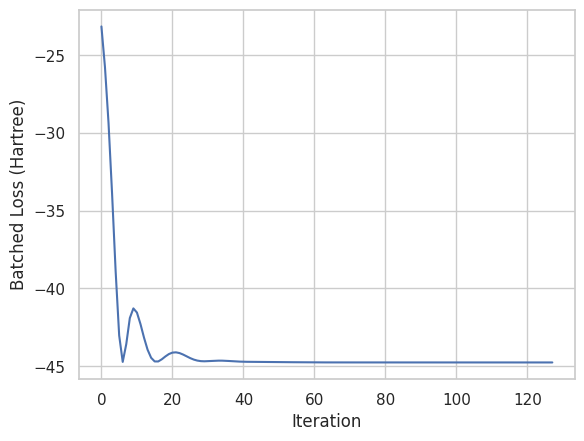

In [9]:
history = jnp.stack(history)
ax = sns.lineplot(history)
ax.set_xlabel("Iteration")
ax.set_ylabel("Batched Loss (Hartree)");

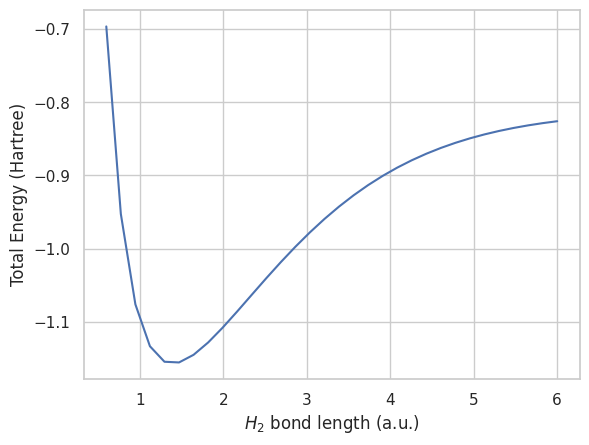

In [8]:
E_n = jax.vmap(nuclear_energy)(H.basis.structure)
E_total = energy(Z, H) + E_n

ax = sns.lineplot(x=rs, y=E_total)
ax.set_xlabel("$H_2$ bond length (a.u.)")
ax.set_ylabel("Total Energy (Hartree)");